# Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
import plotly

C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
conn = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

In [5]:
# Sampling the data :
sample_data = data.sample(n=50000)
sample_data['Score'].value_counts()

positive    42193
negative     7807
Name: Score, dtype: int64

In [6]:
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
168062,483566,522857,B001E5E08S,A2MFFCXONKEACN,"chrism ""online shopper since '95""",3,4,positive,1294444800,Keeps the Hunger away for up to 6 hours!,I've been hooked on this cereal ever since my ...,b'ive hook cereal ever sinc girlfriend wife in...
240797,12009,13080,B002GWHAXK,A28WBK9FUVZDG2,"Richard W. Eilers ""RICHARD E.""",5,5,positive,1266883200,you gotta try this--best for the buck!!,The coffee cartels and monopolies are desperat...,b'coffe cartel monopoli desper tri control mar...


## Time Based Splitting :

In [7]:
# Sorting the sample data using Time column
sorted_sample = sample_data.sort_values(by='Time')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
215,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...


In [8]:
# Getting the Labels i.e the Score out of the dataframe.
y = sorted_sample['Score']
# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
sorted_sample = sorted_sample.drop(columns='Score')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
215,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,b'bought apart infest fruit fli hour trap mani...


In [9]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:40000]
y_train = y[0:40000]
x_test = sorted_sample[40000:50000]
y_test = y[40000:50000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (40000, 11)
Test Set -  (10000, 11)


## Word2Vec :
* We will train W2V on our train dataset.

In [10]:
# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence.decode('utf-8')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [11]:
# converting the train set into clean form which does not contain html tags etc.
import gensim
i=0
list_of_sent_train=[]
for sent in x_train['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

C:\Users\Prakhar\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



In [12]:
# Doing the same for test dataset.
list_of_sent_test=[]
for sent in x_test['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [13]:
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=200, workers=4) 

### Avg-W2V :

In [14]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
print (len(sent_vectors_train))
print (len(sent_vectors_train[0]))

40000
200


In [15]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
print (len(sent_vectors_test))
print (len(sent_vectors_test[0]))

10000
200


#### Decision Tree on AVG-W2V :

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
# Finding Optimal depth using Cross Valiation :) 
depth = [x for x in range(1, 21)]
depth

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [18]:
#calculating cross-val score for each depth
cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d)
    scores = cross_val_score(clf, sent_vectors_train, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

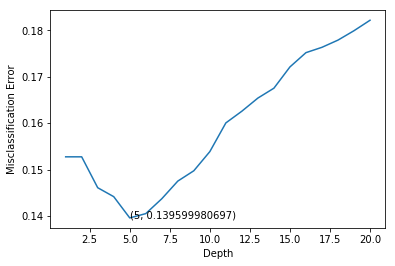

In [19]:
# plotting the error as depth increases
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()

In [20]:
# Filling nan values with 0's.
sent_vectors_test = np.array(sent_vectors_test)
sent_vectors_test = np.nan_to_num(sent_vectors_test)

In [21]:
# Training the model with best max_depth.
clf = DecisionTreeClassifier(max_depth = 5) # MAx depth obtained from CV.
clf.fit(sent_vectors_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
# Accuracy on Test data
clf.score(sent_vectors_test, y_test)

0.85460000000000003

##### Conclusions ->
* The max-depth obtained using CV is 5.
* The plot of max_depth vs Misclassifictaion error is expected, first the error decreases then reahces a minimum at depth of 5 then increases as the model begins to overfit.
* Accuracy on test data with depth of 5 is 85.4 %

## TFIDF-W2V :

In [23]:
# We will first create tfidf w2v features.
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [24]:
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))

40000
200


In [25]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning:

invalid value encountered in true_divide



10000
200


In [26]:
# nan values are assigned 0 (if present)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
tfidf_sent_vectors_test = np.nan_to_num(tfidf_sent_vectors_test)

In [27]:
#calculating cross-val score for each depth
cv_scores = []
for d in depth:
    clf = DecisionTreeClassifier(max_depth = d)
    scores = cross_val_score(clf, tfidf_sent_vectors_train, y_train, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())

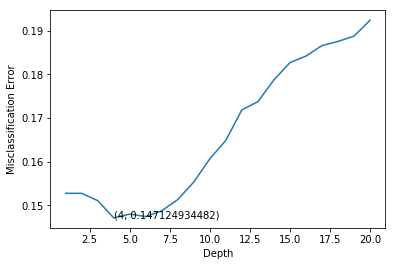

In [28]:
# plotting the error as depth increases
error = [1 - x for x in cv_scores]
optimal_depth = depth[error.index(min(error))]
plt.plot(depth, error)
xy = (optimal_depth, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Depth")
plt.ylabel("Misclassification Error")
plt.show()

In [29]:
# Training the model with best max_depth.
clf = DecisionTreeClassifier(max_depth = 4) # MAx depth obtained from CV.
clf.fit(tfidf_sent_vectors_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
# Accuracy on Test data ->
clf.score(tfidf_sent_vectors_test, y_test)

0.82040000000000002

##### Conclusions ->
* The max_depth obtained using CV is 4.
* The plot of depth vs error is as expected.
* The accuracy of model on test data is 82.04 % , 3% lower than AVG-W2V

<table>
    <tr>
        <th>Model</th><th>Max_Depth</th><th>Accuracy on Test Data</th>
    </tr>
    <tr>
        <td>AVG-W2V</td><td>5</td><td>85.4 %</td>
    </tr>
    <tr>
        <td>TFIDF-W2V</td><td>4</td><td>82.04 %</td>
    </tr>
</table>